In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [38]:
X = np.load('../data/X.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('../data/y.npy')
y = torch.tensor(y, dtype=torch.float32)
X = X[y == 0]
X = (X - X.min()) / (X.max() - X.min())
X = X.reshape(-1, 1, 96)
X.shape

torch.Size([2069, 1, 96])

In [39]:
def auto_cov(X, lag=1):
    X = X - torch.mean(X, axis=2).unsqueeze(2)
    if lag == 0:
        return torch.sum(X * X, axis=2)
    else:
        return (X[:, :, lag:] * X[:, :, :-lag]).sum(axis=2)

def auto_corr(X, lag=1):
    return auto_cov(X, lag) / auto_cov(X, 0)
a = auto_corr(X).mean()
m = X.mean()
s = X.std()
a, m, s

(tensor(0.9690), tensor(0.3147), tensor(0.2253))

In [42]:
class Generator(nn.Module):
    def __init__(self, channels):
        super(Generator, self).__init__()
        self.channels = channels
        self.conv_1 = nn.Conv1d(channels, 16, 5, padding='same')
        self.conv_2 = nn.Conv1d(16, 32, 5, padding='same')
        self.conv_3 = nn.Conv1d(32, 16, 5, padding='same')
        self.conv_4 = nn.Conv1d(16 + channels, channels, 5, padding='same')
        self.batch_norm = nn.BatchNorm1d(channels)

    def forward(self, x):
        x_ = x
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = torch.cat([x, x_], dim=1)
        x = self.conv_4(x)
        x = F.sigmoid(self.batch_norm(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.pool = nn.MaxPool1d(2)
        self.conv1 = nn.Conv1d(channels, 8, 5, padding='same')
        self.conv2 = nn.Conv1d(8, 16, 5, padding='same')
        self.conv3 = nn.Conv1d(16, 16, 5, padding='same')
        self.conv4 = nn.Conv1d(16, 16, 5, padding='same')
        self.fc1 = nn.Linear(16*6, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 16*6)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [43]:
channels = 8
batch_size = 256
minibatch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator(channels)
G.to(device)
D = Discriminator(channels)
D.to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=1e-5)
optimizer_D = optim.Adam(D.parameters(), lr=1e-5)

n_sub_epochs = [(20, 10)]*15
num_epochs = sum([sum(sub_epoch) for sub_epoch in n_sub_epochs])
epoch = 0
best_score = float('inf')
for sub_epoch in n_sub_epochs:
    for _ in range(sub_epoch[0]):
        for _ in range(batch_size):
            real_data = X[np.random.choice(X.shape[0], minibatch_size*channels, replace=False)].reshape(-1, channels, 96).to(device)
            optimizer_D.zero_grad()
            D_real = D(real_data)
            D_real_loss = criterion(D_real, torch.ones_like(D_real))
            
            fake_data = G(torch.randn(32, channels, 96, device=device))
            D_fake = D(fake_data.detach())
            D_fake_loss = criterion(D_fake, torch.zeros_like(D_fake))

            D_loss = D_real_loss + D_fake_loss
            D_loss.backward()
            optimizer_D.step()

        epoch += 1
        print(f"Epoch {epoch}/{num_epochs}, D Loss: {D_loss.item()}")

    for _ in range(sub_epoch[1]):
        for _ in range(batch_size):
            optimizer_G.zero_grad()
            fake_data = G(torch.randn(32, channels, 96, device=device))
            output = D(fake_data)
            
            G_loss = criterion(output, torch.ones_like(output))
            G_loss.backward()
            optimizer_G.step()

        epoch += 1
        print(f"Epoch {epoch}/{num_epochs}, G Loss: {G_loss.item()}")

    fake_data = G(torch.randn(100, channels, 96, device=device))
    a_fake = auto_corr(fake_data.squeeze()).mean()
    m_fake = fake_data.mean()
    s_fake = fake_data.std()
    print(f"a_fake: {a_fake}, m_fake: {m_fake}, s_fake: {s_fake}")
    score = (a_fake - a)**2 + (m_fake - m)**2 + (s_fake - s)**2
    if score < best_score:
        best_score = score
        best_G = G
        print(f"Best score: {score}")

Epoch 1/450, D Loss: 1.3808372020721436
Epoch 2/450, D Loss: 1.370161771774292
Epoch 3/450, D Loss: 1.3436315059661865
Epoch 4/450, D Loss: 1.293776035308838
Epoch 5/450, D Loss: 1.2053816318511963
Epoch 6/450, D Loss: 1.097500205039978
Epoch 7/450, D Loss: 0.9852054715156555
Epoch 8/450, D Loss: 0.8076805472373962
Epoch 9/450, D Loss: 0.6424626111984253
Epoch 10/450, D Loss: 0.522918701171875
Epoch 11/450, D Loss: 0.35665711760520935
Epoch 12/450, D Loss: 0.385220468044281
Epoch 13/450, D Loss: 0.22602467238903046
Epoch 14/450, D Loss: 0.13866065442562103
Epoch 15/450, D Loss: 0.10302795469760895
Epoch 16/450, D Loss: 0.059751320630311966
Epoch 17/450, D Loss: 0.08282356709241867
Epoch 18/450, D Loss: 0.05437329411506653
Epoch 19/450, D Loss: 0.025267720222473145
Epoch 20/450, D Loss: 0.06874511390924454
Epoch 21/450, G Loss: 4.583491802215576
Epoch 22/450, G Loss: 4.102784156799316
Epoch 23/450, G Loss: 3.371295928955078
Epoch 24/450, G Loss: 2.4527928829193115
Epoch 25/450, G Loss: 

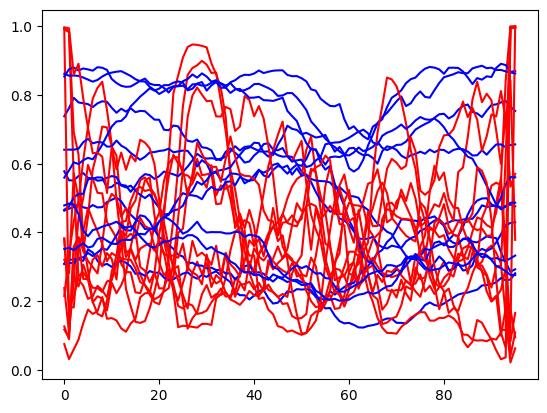

In [44]:
best_G.eval()
fake_data = best_G(torch.randn(2, channels, 96, device=device)).reshape(-1, 96).cpu()
for i in range(12):
    plt.plot(fake_data[i].detach().numpy(), color='red')
    plt.plot(X[i, 0].detach().numpy(), color='blue')
plt.show()

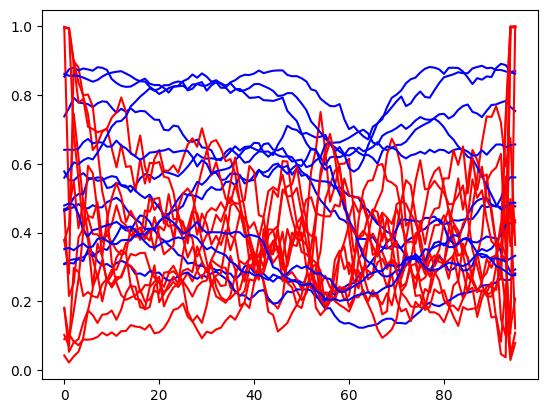

In [45]:
G.eval()
fake_data = G(torch.randn(2, channels, 96, device=device)).reshape(-1, 96).cpu()
for i in range(12):
    plt.plot(fake_data[i].detach().numpy(), color='red')
    plt.plot(X[i, 0].detach().numpy(), color='blue')
plt.show()